In [1]:
import os
import pickle
import multiprocessing as mp
import math
import pandas as pd

In [2]:

base_paths = [
    '/home/combined_everything_FL/run_data/d_snn_atks_defs_surrs',
    '/home/combined_everything_FL/run_data/d_ipm_increased_scale',
    '/home/combined_everything_FL/run_data/d_ann_atks_defs',
    '/home/combined_everything_FL/run_data/d_decrease_gaussian_std'
]
file_paths = [os.path.join(base_path, f) for base_path in base_paths for f in os.listdir(base_path) if f.startswith('exp_')]
class ExpRecord:
    pass

In [3]:
exps = []
for path in file_paths:
    exp = pickle.load(open(path, 'rb'))
    if exp.attack['type'] == 'IPM' and exp.attack['params']['scale'] == 0.1:
        continue
    if exp.attack['type'] == 'GaussRandom' and ('std' not in exp.attack['params'] or exp.attack['params']['std'] != 1.0):
        continue
    # if exp.attack['type'] == 'GaussRandom':
    #     print(exp.attack)
    exps.append(exp)
print(len(exps))

1032


In [4]:
data = []
for exp in exps:
    if len(getattr(exp, 'test_accs', [])) == 0 or getattr(exp, 'checkpointed_epoch', None) != 2000:
        continue
    # Extract the attributes from each experiment
    row = {
        'model': exp.model,
        'data': exp.dataset,
        'surr': exp.snn_hyperparams['surrogate']['type'][:-4] if exp.model.startswith('snn') else 'None',
        'atk': str(exp.attack['type']),
        'def': exp.aggregator['type'],
        'best_acc': max([i[1] for i in exp.test_accs]),
    }
    if row['surr'] == 'FastSigmoid': 
        row['surr'] = 'Fast-sigmoid'
    if row['atk'] == 'SignFlip': 
        row['atk'] = 'S.F.'
    elif row['atk'] == 'LabelFlip': 
        row['atk'] = 'L.F.'
    elif row['atk'] == 'GaussRandom': 
        row['atk'] = 'G.R.'

    if row['def'] == 'SignGuard': 
        row['def'] = 'S.G.'
    elif row['def'] == 'CenterClipping':
        row['def'] = 'C.C.'
    elif row['def'] == 'NormClipping':
        row['def'] = 'N.C.'

    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)

# Display the first few rows
df.head()

,model,data,surr,atk,def,best_acc
0,snn_vgg9,CIFAR10,Rectangle,MinMax,DnC,0.7202
1,snn_vgg9,CIFAR100,Rectangle,MinMax,RFA,0.0191
2,snn_vgg9,CIFAR10,Gaussian,L.F.,Mean,0.4522
3,snn_vgg9,CIFAR100,Triangle,MinMax,DnC,0.4641
4,snn_vgg9,CIFAR10,Rectangle,MinMax,RFA,0.1146


In [5]:
import re

def parse_csv_string(csv_string):
    """Parse a CSV string with a specific format where the first line contains column headers."""
    lines = csv_string.strip().split('\n')
    
    # Parse header line
    header_line = lines[0]
    columns = header_line.split(',')
    
    # Extract dataset and defense names
    datasets = []
    defenses = []
    for col in columns[1:]:  # Skip the first column (attack name)
        if re.match(r'[A-Za-z0-9]+_[A-Za-z0-9.]+', col):
            parts = col.split('_')
            dataset = parts[0]
            defense = parts[1]
            
            if dataset not in datasets:
                datasets.append(dataset)
            if defense not in defenses:
                defenses.append(defense)
    
    # Sort unique defenses to ensure consistent order
    defenses = list(dict.fromkeys(defenses))
    
    # Parse data lines
    data = []
    for line in lines[1:]:
        if not line.strip():
            continue
        values = line.split(',')
        attack_name = values[0]
        numeric_values = [float(v) for v in values[1:]]
        data.append([attack_name] + numeric_values)
    
    return columns, datasets, defenses, data

def generate_latex_table(csv_string, decimals=2):
    """Generate a LaTeX table from CSV data with specified number of decimal places."""
    columns, datasets, defenses, data = parse_csv_string(csv_string)
    
    # Start building the LaTeX code
    latex = [
        "\\documentclass{article}",
        "\\usepackage{booktabs}",
        "\\usepackage{multirow}",
        "\\usepackage{array}",
        "\\usepackage{colortbl}",
        "\\usepackage{xcolor}",
        "\\usepackage{pdflscape}",
        "\\usepackage{siunitx}",
        "",
        "\\begin{document}",
        "",
        "\\begin{landscape}",
        "\\begin{table}",
        "\\centering",
        "\\small",
        "\\setlength{\\tabcolsep}{3.5pt}",
        "\\caption{Attack Performance across Datasets and Defenses}",
        f"\\begin{{tabular}}{{l*{{{len(columns)-1}}}{{S[table-format=-1.{decimals}]}}}}",
        "\\toprule"
    ]
    
    # Add the dataset headers
    dataset_header = "\\multirow{2}{*}{atk}"
    for dataset in datasets:
        dataset_count = sum(1 for col in columns if col.startswith(f"{dataset}_"))
        dataset_header += f" & \\multicolumn{{{dataset_count}}}{{c}}{{{dataset}}}"
    latex.append(dataset_header + " \\\\")
    
    # Add the cmidrule separators
    cmidrules = []
    start_idx = 2
    for dataset in datasets:
        dataset_count = sum(1 for col in columns if col.startswith(f"{dataset}_"))
        end_idx = start_idx + dataset_count - 1
        cmidrules.append(f"\\cmidrule(lr){{{start_idx}-{end_idx}}}")
        start_idx = end_idx + 1
    latex.append(" ".join(cmidrules))
    
    # Add the defense headers
    defense_header = " "
    for col in columns[1:]:
        defense = col.split('_')[1]
        defense_header += f" & {{{defense}}}"
    latex.append(defense_header + " \\\\")
    latex.append("\\midrule")
    
    # Add the data rows
    for row in data:
        attack_name = row[0]
        values = [f"{val:.{decimals}f}" for val in row[1:]]
        latex.append(f"{attack_name} & " + " & ".join(values) + " \\\\")
    
    # Finish the table
    latex.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\end{table}",
        "\\end{landscape}",
        "",
        "\\end{document}"
    ])
    
    return "\n".join(latex)


## Effect of attacks on different Surrogate Gradients

In [6]:
snn_atk_no_def = df[(df['model'].str.startswith('snn')) & (df['def'] == 'Mean') & (df['atk'] != 'None')]
snn_no_atk_no_def = df[(df['model'].str.startswith('snn')) & (df['def'] == 'Mean') & (df['atk'] == 'None')]

In [7]:
a, b = snn_atk_no_def, snn_no_atk_no_def
# a.loc[a['surr'] == 'Triangle', 'surr'] = 'T'
# a.loc[a['surr'] == 'Gaussian', 'surr'] = 'G'
# a.loc[a['surr'] == 'Rectangle', 'surr'] = 'R'
# a.loc[a['surr'] == 'Quadratic', 'surr'] = 'Q'
# a.loc[a['surr'] == 'FastSigmoid', 'surr'] = 'F'
# b.loc[b['surr'] == 'Triangle', 'surr'] = 'T'
# b.loc[b['surr'] == 'Gaussian', 'surr'] = 'G'
# b.loc[b['surr'] == 'Rectangle', 'surr'] = 'R'
# b.loc[b['surr'] == 'Quadratic', 'surr'] = 'Q'
# b.loc[b['surr'] == 'FastSigmoid', 'surr'] = 'F'
c = pd.merge(a,b,'left', ['model', 'data', 'surr', 'def']).sort_values(['model', 'data', 'atk_x', 'surr'])
c['acc_loss'] = c['best_acc_y'] - c['best_acc_x']
c['data_surr'] = c['data'] + '_' + c['surr']
d = c.pivot(
    index='atk_x',
    columns='data_surr',
    values='acc_loss'
)

In [8]:
c

,model,data,surr,atk_x,def,best_acc_x,atk_y,best_acc_y,acc_loss,data_surr
22,snn_fc,FMNIST,Fast-sigmoid,Fang,Mean,0.8504,None,0.8672,0.0168,FMNIST_Fast-sigmoid
88,snn_fc,FMNIST,Gaussian,Fang,Mean,0.8413,None,0.8635,0.0222,FMNIST_Gaussian
92,snn_fc,FMNIST,Quadratic,Fang,Mean,0.8419,None,0.8644,0.0225,FMNIST_Quadratic
61,snn_fc,FMNIST,Rectangle,Fang,Mean,0.8452,None,0.8667,0.0215,FMNIST_Rectangle
45,snn_fc,FMNIST,Triangle,Fang,Mean,0.8399,None,0.8623,0.0224,FMNIST_Triangle
...,...,...,...,...,...,...,...,...,...,...
71,snn_vgg9,CIFAR100,Fast-sigmoid,S.F.,Mean,0.0644,None,0.4005,0.3361,CIFAR100_Fast-sigmoid
81,snn_vgg9,CIFAR100,Gaussian,S.F.,Mean,0.0668,None,0.3978,0.3310,CIFAR100_Gaussian
32,snn_vgg9,CIFAR100,Quadratic,S.F.,Mean,0.0691,None,0.4398,0.3707,CIFAR100_Quadratic
21,snn_vgg9,CIFAR100,Rectangle,S.F.,Mean,0.0604,None,0.3997,0.3393,CIFAR100_Rectangle


In [9]:
# print(generate_latex_table(d.to_csv(index=True), decimals=2))

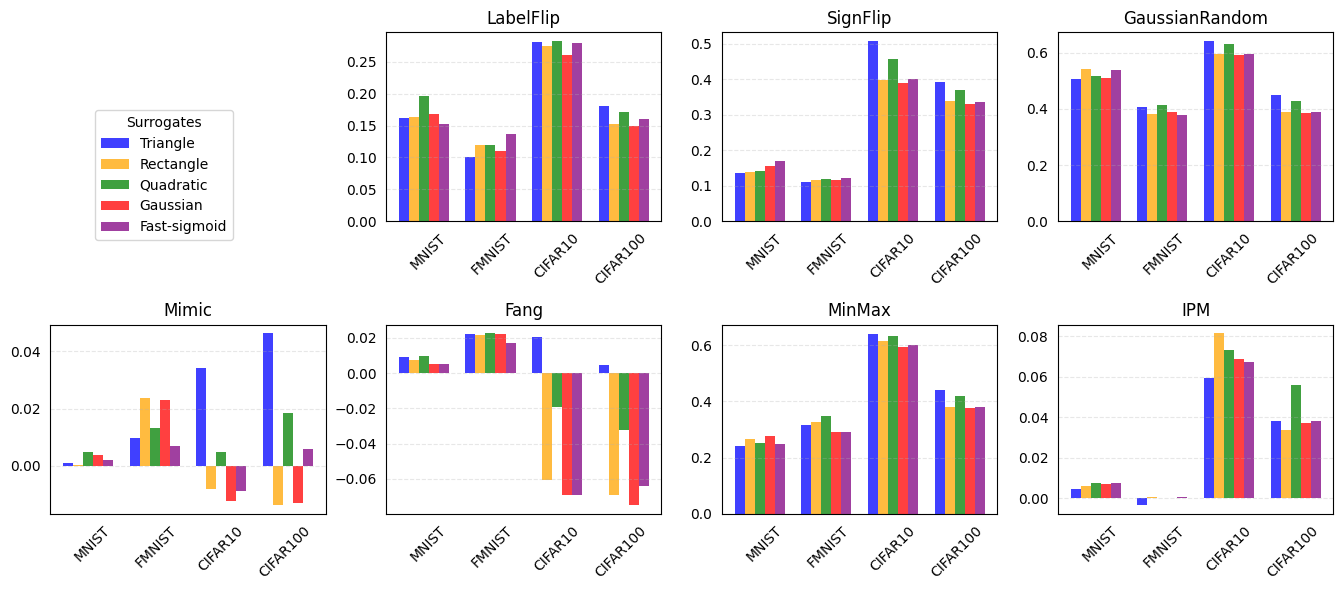

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with more height to accommodate legend and tilted labels
fig = plt.figure(figsize=(15, 6))

surrs = ['Triangle', 'Rectangle', 'Quadratic', 'Gaussian', 'Fast-sigmoid']
atks = ['L.F.', 'S.F.', 'G.R.', 'Mimic', 'Fang', 'MinMax', 'IPM']
atks_fullname = ['LabelFlip', 'SignFlip', 'GaussianRandom', 'Mimic', 'Fang', 'MinMax', 'IPM']
surr_colors = [
    'blue',
    'orange', 
    'green',
    'red',
    'purple'
]
dses = ['MNIST', 'FMNIST', 'CIFAR10', 'CIFAR100']
bar_w = 0.15

# Create a list to store legend handles
legend_handles = []

for atk in atks:
    ax = fig.add_subplot(2, 4, atks.index(atk) + 2)
    ds_xes = np.arange(1, 5.1, 1)
    
    for ds, ds_x in zip(dses, ds_xes):
        surr_xes = np.arange(ds_x, ds_x + 5 * bar_w - bar_w/2, bar_w) - 2 * bar_w
        for surr, surr_x in zip(surrs, surr_xes):
            # Store the bar handle for the first subplot only (for legend)
            bar = ax.bar(surr_x, 
                        c[(c['data'] == ds) & (c['atk_x'] == atk) & (c['surr'] == surr)]['acc_loss'].item(), 
                        bar_w,
                        color=surr_colors[surrs.index(surr)],
                        alpha=0.75
                        )
            if atks.index(atk) == 0:
                legend_handles.append(bar[0])

    ax.tick_params(color='None')
    ax.set_xticks(np.arange(1, 4.1, 1) + 2.5 * bar_w)
    ax.set_xticklabels(dses, rotation=45, ha='right')  # Rotate labels 45 degrees
    ax.set_title(atks_fullname[atks.index(atk)])
    
    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a single legend outside all subplots
fig.legend(legend_handles, surrs, 
          loc='center left', 
          bbox_to_anchor=(0.07, 0.7),
          title='Surrogates')

# Adjust the right margin to make room for the legend
plt.subplots_adjust(right=0.9)

plt.show()